In [3]:
import os, sys
from os.path import join

import nibabel as nib
import numpy as np
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Make timing files for each run

   - each run was composed of 6 blocks. Each block began with 20s of rest, and then 10s of task (either motor squeezing or imagery)
   - there was 6 seconds of disdaqs at the beginning
   - However, the data collection started 2 TRs AFTER the task started. Thus with a TR of 1s, there were 2 seconds of task before the task started. Likewise, for a TR of 2s, there was 4 seconds of task before the task started. This was due to the 2 dummy scans that Philips inserts at the beginning of the each scan

In [4]:
trialStarts = []
currentTime = 0

for b in range(6):
    # start time for rest
    trialStarts.append(currentTime)

    # increment by rest duration
    currentTime += 20
    
    # start time for task
    trialStarts.append(currentTime)
    
    # increment by the task duration
    currentTime += 10

# add in offset for 
trialStarts = np.array(trialStarts) + 6

In [5]:
## make separate arrays for TR=1s and TR=2s
# subtract 2 dummy scans (2s)
onsets_1sTR = trialStarts - 2

# subtract 2 dummy scans (4s)
onsets_2sTR = trialStarts - 4

In [6]:
# hardcoded order on each run
trialTypes = ['rest', 'motor', 
             'rest', 'imagery',
             'rest', 'imagery',
             'rest', 'motor',
             'rest', 'imagery',
             'rest', 'motor']


In [7]:
# make a dataframe
trialOnsets = pd.DataFrame({'trialTypes': trialTypes, 'onsets_TR1': onsets_1sTR, 'onsets_TR2': onsets_2sTR, 'weights': np.ones(onsets_1sTR.shape)})

In [8]:
def trialDuration(row):
    if row['trialTypes'] == 'rest':
        val = 20
    else:
        val = 10
    return val
trialOnsets['duration'] = trialOnsets.apply(trialDuration, axis=1)

In [9]:
trialOnsets

,onsets_TR1,onsets_TR2,trialTypes,weights,duration
0,4,2,rest,1.0,20
1,24,22,motor,1.0,10
2,34,32,rest,1.0,20
3,54,52,imagery,1.0,10
4,64,62,rest,1.0,20
5,84,82,imagery,1.0,10
6,94,92,rest,1.0,20
7,114,112,motor,1.0,10
8,124,122,rest,1.0,20
9,144,142,imagery,1.0,10


### Write out FSL 3col files

In [63]:
# 1s TR files
for trialType in ['rest', 'motor', 'imagery']:
    df = trialOnsets.loc[trialOnsets.trialTypes == trialType, ['onsets_TR1','duration', 'weights']]
    df.to_csv('../data/subject001/timingFiles/TR1_{}.txt'.format(trialType),
              sep='\t', 
              header=False,
              index=False)
    
# 2s TR files
for trialType in ['rest', 'motor', 'imagery']:
    df = trialOnsets.loc[trialOnsets.trialTypes == trialType, ['onsets_TR2','duration', 'weights']]
    df.to_csv('../data/subject001/timingFiles/TR2_{}.txt'.format(trialType),
              sep='\t', 
              header=False,
              index=False)

# Prep Masks

For localizer-based masks, we analyzed the first run (pyneal_002) and computed constrast stats for `motor > rest` and `imagery > rest`. For each contrast, we took the coordinates of the voxel with the max zstat:

* **motor > rest**: (28, 28, 10)
* **imagery > rest**: (34, 35, 14)

Since each run has different slice prescriptions and coverage, we need to convert these coordinates to MNI space, draw a 5mm sphere around the point, and save as a new mask.

Then, for each run, transform the MNI-space mask down to subject functional space for that run. Mask by the whole brain mask to make sure no non-brain voxels are incldued in the final mask

### Convert peak coordinate for each contrast to MNI space

In [23]:
# motor > rest peak coord in MNI space
!echo 28 28 10 | img2imgcoord -src ../data/subject001/pyneal_002/exampleFunc.nii.gz -dest /usr/local/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz -xfm ../data/subject001/pyneal_002/mask_transforms/func2mni.mat

Coordinates in Destination volume (in voxels)
126.749  90.0093  133.427


In [25]:
# imagery > rest peak coord in MNI space
!echo 34 35 14 | img2imgcoord -src ../data/subject001/pyneal_002/exampleFunc.nii.gz -dest /usr/local/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz -xfm ../data/subject001/pyneal_002/mask_transforms/func2mni.mat

Coordinates in Destination volume (in voxels)
108.378  114.904  145.219


### Make 5mm sphere mask in MNI space around each peak

In [30]:
# motor > rest
!fslmaths /usr/local/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz -mul 0 -add 1 -roi 127 1 90 1 133 1 0 1 tmpMotorPoint_MNI -odt float

!fslmaths tmpMotorPoint_MNI.nii.gz -kernel sphere 5 -fmean -bin ../data/subject001/masks/motorSphere_5mm_MNI -odt float

!rm tmpMotorPoint_MNI.nii.gz

In [31]:
# imagery > rest
!fslmaths /usr/local/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz -mul 0 -add 1 -roi 108 1 114 1 145 1 0 1 tmpImageryPoint_MNI -odt float

!fslmaths tmpImageryPoint_MNI.nii.gz -kernel sphere 5 -fmean -bin ../data/subject001/masks/imagerySphere_5mm_MNI -odt float

!rm tmpImageryPoint_MNI.nii.gz

In [45]:
%%bash
# mask each sphere by the whole brain mask to make sure there is no non-brain voxels included
for run in pyneal_002 pyneal_003 pyneal_004 pyneal_005; do
    maskDir=../data/subject001/$run/mask_transforms/FUNC_masks
    
    # motorSphere
    fslmaths ${maskDir}/motorSphere_5mm_FUNC_mask.nii.gz -mul ${maskDir}/wholeBrain_FUNC_mask.nii.gz ${maskDir}/motorSphere_5mm_FUNC_mask.nii.gz

    # imagerySphere
    fslmaths ${maskDir}/imagerySphere_5mm_FUNC_mask.nii.gz -mul ${maskDir}/wholeBrain_FUNC_mask.nii.gz ${maskDir}/imagerySphere_5mm_FUNC_mask.nii.gz

done

# Pull out timeseries from the masks for each run

### Motor Region:

In [51]:
from nilearn.masking import apply_mask

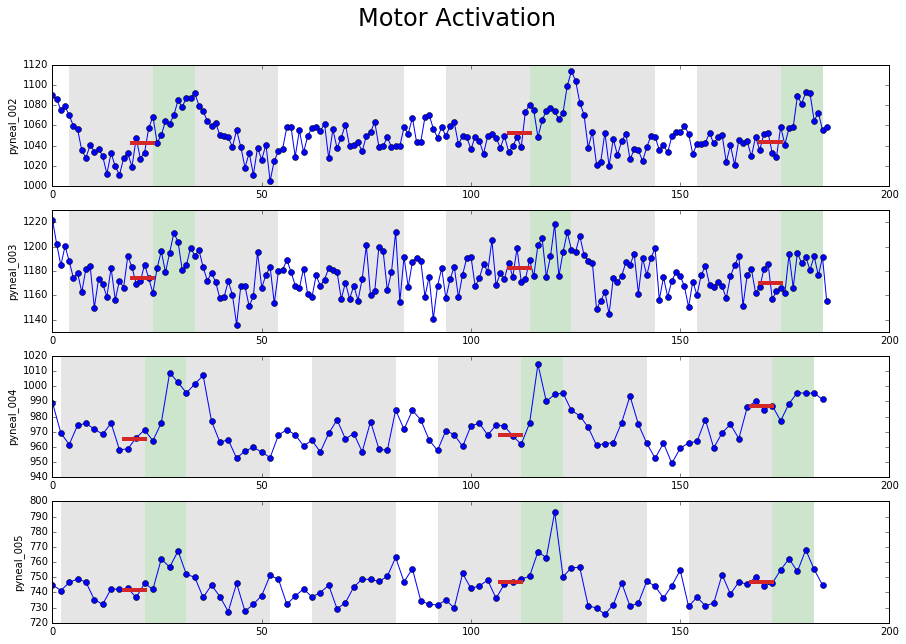

In [104]:
# start the plot
fig, axs = plt.subplots(4, 1, figsize=(15,10))
plt.suptitle('Motor Activation', fontsize=24)
#fig.subplots_adjust(vspace=.5)


for i,run in enumerate(['pyneal_002', 'pyneal_003', 'pyneal_004', 'pyneal_005']):
    # load the motor sphere mask
    motorMask = nib.load('../data/subject001/{}/mask_transforms/FUNC_masks/motorSphere_5mm_FUNC_mask.nii.gz'.format(run))
    
    # load the masked run data
    rawFunc = '../data/subject001/{}/receivedFunc.nii.gz'.format(run)
    maskedData = apply_mask(rawFunc, motorMask)
    
    # calculate the mean timeseries within mask
    meanTS = np.mean(maskedData, axis=1)
    
    # plot
    if run in ['pyneal_002', 'pyneal_003']:
        # use 1s TR
        x = np.arange(0,186,1)
        
        # get onsets for trials
        restOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'rest', ['onsets_TR1','duration']]
        restOnsets.rename(index=str, columns={"onsets_TR1":"onsets"}, inplace=True)
        motorOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'motor', ['onsets_TR1', 'duration']]
        motorOnsets.rename(index=str, columns={"onsets_TR1":"onsets"}, inplace=True)
  
    else:
        # use 2s TR
        x = np.arange(0,186,2)
        
        # get onsets for trials
        restOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'rest', ['onsets_TR2','duration']]
        restOnsets.rename(index=str, columns={"onsets_TR2":"onsets"}, inplace=True)
        motorOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'motor', ['onsets_TR2', 'duration']]
        motorOnsets.rename(index=str, columns={"onsets_TR2":"onsets"}, inplace=True)
    
    # plot mean ts
    axs[i].plot(x, meanTS, '-o')
    axs[i].set(ylabel=run)
    
    # plot trial spans
    for r,row in restOnsets.iterrows():
        onset = row['onsets']
        axs[i].axvspan(onset, onset+row['duration'], facecolor='gray', edgecolor='none', alpha=0.2)
    
    for r,row in motorOnsets.iterrows():
        onset = row['onsets']
        axs[i].axvspan(onset, onset+row['duration'], facecolor='green', edgecolor='none', alpha=0.2)
        
    # plot trial baselines (based on last few seconds of rest trial preceding motor trial)
    baselineWindow = 5 # in sec
    for r,row in motorOnsets.iterrows():  
        onset = row['onsets']
        xMask = (x >= onset-baselineWindow) & (x<=onset)   # create mask for baseline window
        
        # calculate the baseline for this trial
        thisBline = np.mean(meanTS[xMask])
        
        # draw it
        blineX = np.array([onset-baselineWindow, onset])
        blineY = np.array([thisBline, thisBline])
        axs[i].plot(blineX, blineY, linewidth=4, color='#d62728')
        



In the plot above, the blue lines show the mean activation from the 5mm motor sphere over the course of the entire run

The horizontal red bars indicate the pre-trial baseline (calculated as the average activation over a 5s window preceding each **Motor** trial. 

- The top two plots (**pyneal_002** and **pyneal_003**) have a 1s TR
- Bottom two plots ((**pyneal_004** and **pyneal_005**) have a 2s TR

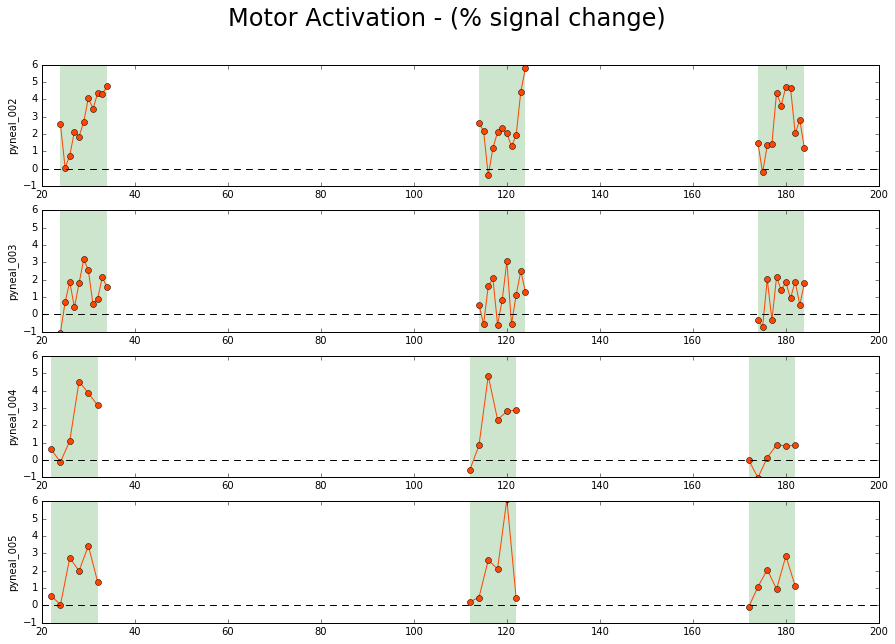

In [115]:
# start the plot
fig, axs = plt.subplots(4, 1, figsize=(15,10))
plt.suptitle('Motor Activation - (% signal change)', fontsize=24)
#fig.subplots_adjust(vspace=.5)


for i,run in enumerate(['pyneal_002', 'pyneal_003', 'pyneal_004', 'pyneal_005']):
    # load the motor sphere mask
    motorMask = nib.load('../data/subject001/{}/mask_transforms/FUNC_masks/motorSphere_5mm_FUNC_mask.nii.gz'.format(run))
    
    # load the masked run data
    rawFunc = '../data/subject001/{}/receivedFunc.nii.gz'.format(run)
    maskedData = apply_mask(rawFunc, motorMask)
    
    # calculate the mean timeseries within mask
    meanTS = np.mean(maskedData, axis=1)
    
    # plot
    if run in ['pyneal_002', 'pyneal_003']:
        # use 1s TR
        x = np.arange(0,186,1)
        
        # get onsets for trials
        restOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'rest', ['onsets_TR1','duration']]
        restOnsets.rename(index=str, columns={"onsets_TR1":"onsets"}, inplace=True)
        motorOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'motor', ['onsets_TR1', 'duration']]
        motorOnsets.rename(index=str, columns={"onsets_TR1":"onsets"}, inplace=True)
  
    else:
        # use 2s TR
        x = np.arange(0,186,2)
        
        # get onsets for trials
        restOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'rest', ['onsets_TR2','duration']]
        restOnsets.rename(index=str, columns={"onsets_TR2":"onsets"}, inplace=True)
        motorOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'motor', ['onsets_TR2', 'duration']]
        motorOnsets.rename(index=str, columns={"onsets_TR2":"onsets"}, inplace=True)
    
    axs[i].set(ylabel=run)
        
    # plot trial baselines (based on last few seconds of rest trial preceding motor trial)
    baselineWindow = 5 # in sec
    for r,row in motorOnsets.iterrows():  
        onset = row['onsets']
        xBlineMask = (x >= onset-baselineWindow) & (x<=onset)   # create mask for baseline window
        
        # calculate the baseline for this trial
        thisBline = np.mean(meanTS[xBlineMask])
        
        # grab the raw value for this trial only
        xTrialMask = (x >= onset) & (x <= onset + row['duration'])
        trialTS = meanTS[xTrialMask]
        
        # convert trial TS to % signal change from baseline
        trialPercentChange = [((x/thisBline)-1)*100 for x in trialTS]
                
        # draw span
        axs[i].axvspan(onset, onset+row['duration'], facecolor='green', edgecolor='none', alpha=0.2)
    
        # draw % signal change
        axs[i].plot(x[xTrialMask], trialPercentChange, '-o', color='orangered')
        
        # format plot
        axs[i].axhline(y=0, color='k', ls='--')
        axs[i].set_ylim(-1,6)


This plot shows activation within the 5mm motor sphere during each motor trial, represented as percent signal change relative to the pre-trial baseline.

---

### Imagery Region:

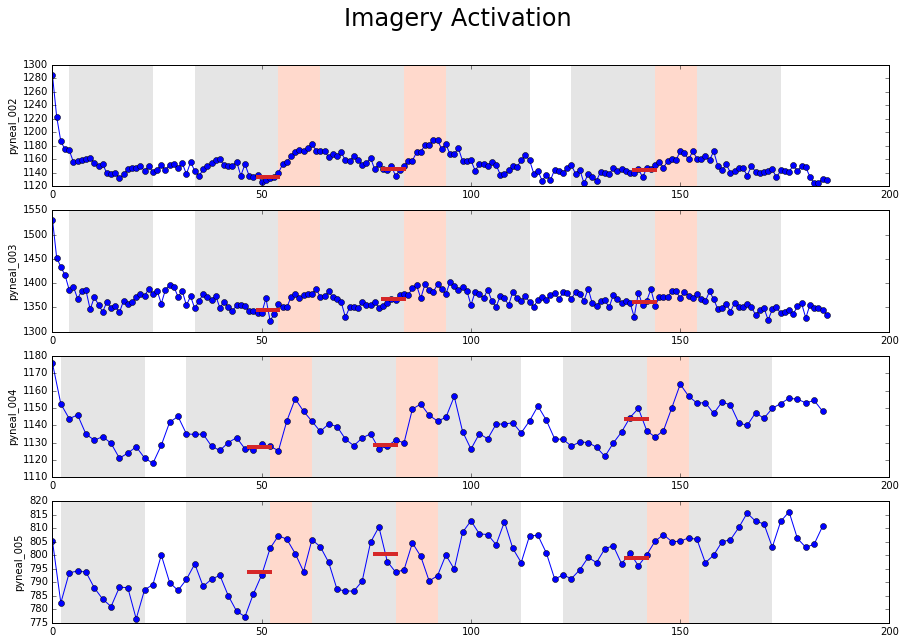

In [117]:
# start the plot
fig, axs = plt.subplots(4, 1, figsize=(15,10))
plt.suptitle('Imagery Activation', fontsize=24)
#fig.subplots_adjust(vspace=.5)


for i,run in enumerate(['pyneal_002', 'pyneal_003', 'pyneal_004', 'pyneal_005']):
    # load the imagery sphere mask
    imageryMask = nib.load('../data/subject001/{}/mask_transforms/FUNC_masks/imagerySphere_5mm_FUNC_mask.nii.gz'.format(run))
    
    # load the masked run data
    rawFunc = '../data/subject001/{}/receivedFunc.nii.gz'.format(run)
    maskedData = apply_mask(rawFunc, imageryMask)
    
    # calculate the mean timeseries within mask
    meanTS = np.mean(maskedData, axis=1)
    
    # plot
    if run in ['pyneal_002', 'pyneal_003']:
        # use 1s TR
        x = np.arange(0,186,1)
        
        # get onsets for trials
        restOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'rest', ['onsets_TR1','duration']]
        restOnsets.rename(index=str, columns={"onsets_TR1":"onsets"}, inplace=True)
        imageryOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'imagery', ['onsets_TR1', 'duration']]
        imageryOnsets.rename(index=str, columns={"onsets_TR1":"onsets"}, inplace=True)
  
    else:
        # use 2s TR
        x = np.arange(0,186,2)
        
        # get onsets for trials
        restOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'rest', ['onsets_TR2','duration']]
        restOnsets.rename(index=str, columns={"onsets_TR2":"onsets"}, inplace=True)
        imageryOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'imagery', ['onsets_TR2', 'duration']]
        imageryOnsets.rename(index=str, columns={"onsets_TR2":"onsets"}, inplace=True)
    
    # plot mean ts
    axs[i].plot(x, meanTS, '-o')
    axs[i].set(ylabel=run)
    
    # plot trial spans
    for r,row in restOnsets.iterrows():
        onset = row['onsets']
        axs[i].axvspan(onset, onset+row['duration'], facecolor='gray', edgecolor='none', alpha=0.2)
    
    for r,row in imageryOnsets.iterrows():
        onset = row['onsets']
        axs[i].axvspan(onset, onset+row['duration'], facecolor='orangered', edgecolor='none', alpha=0.2)
        
    # plot trial baselines (based on last few seconds of rest trial preceding imagery trial)
    baselineWindow = 5 # in sec
    for r,row in imageryOnsets.iterrows():  
        onset = row['onsets']
        xMask = (x >= onset-baselineWindow) & (x<=onset)   # create mask for baseline window
        
        # calculate the baseline for this trial
        thisBline = np.mean(meanTS[xMask])
        
        # draw it
        blineX = np.array([onset-baselineWindow, onset])
        blineY = np.array([thisBline, thisBline])
        axs[i].plot(blineX, blineY, linewidth=4, color='#d62728')

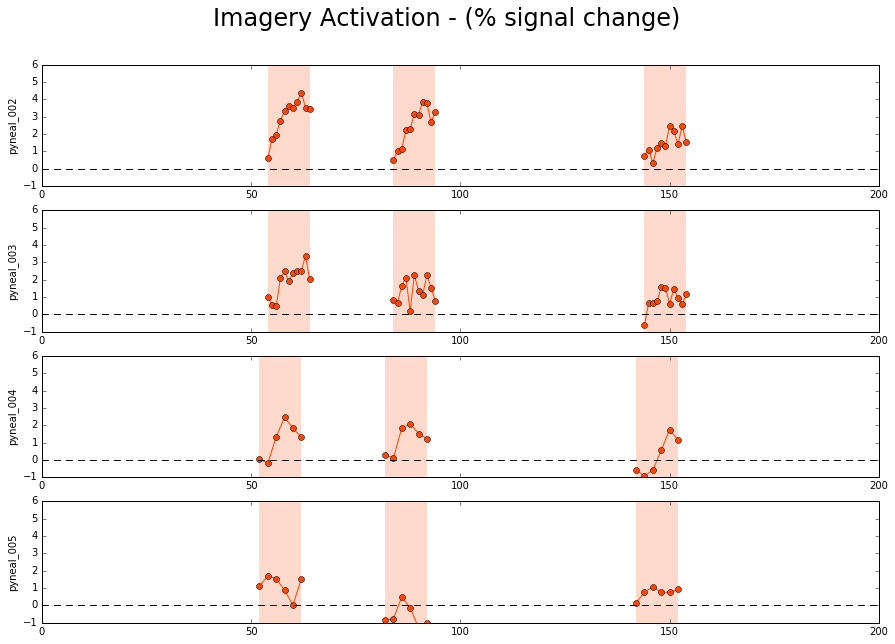

In [120]:
# start the plot
fig, axs = plt.subplots(4, 1, figsize=(15,10))
plt.suptitle('Imagery Activation - (% signal change)', fontsize=24)
#fig.subplots_adjust(vspace=.5)


for i,run in enumerate(['pyneal_002', 'pyneal_003', 'pyneal_004', 'pyneal_005']):
    # load the imagery sphere mask
    imageryMask = nib.load('../data/subject001/{}/mask_transforms/FUNC_masks/imagerySphere_5mm_FUNC_mask.nii.gz'.format(run))
    
    # load the masked run data
    rawFunc = '../data/subject001/{}/receivedFunc.nii.gz'.format(run)
    maskedData = apply_mask(rawFunc, imageryMask)
    
    # calculate the mean timeseries within mask
    meanTS = np.mean(maskedData, axis=1)
    
    # plot
    if run in ['pyneal_002', 'pyneal_003']:
        # use 1s TR
        x = np.arange(0,186,1)
        
        # get onsets for trials
        restOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'rest', ['onsets_TR1','duration']]
        restOnsets.rename(index=str, columns={"onsets_TR1":"onsets"}, inplace=True)
        imageryOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'imagery', ['onsets_TR1', 'duration']]
        imageryOnsets.rename(index=str, columns={"onsets_TR1":"onsets"}, inplace=True)
  
    else:
        # use 2s TR
        x = np.arange(0,186,2)
        
        # get onsets for trials
        restOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'rest', ['onsets_TR2','duration']]
        restOnsets.rename(index=str, columns={"onsets_TR2":"onsets"}, inplace=True)
        imageryOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'imagery', ['onsets_TR2', 'duration']]
        imageryOnsets.rename(index=str, columns={"onsets_TR2":"onsets"}, inplace=True)
    
    axs[i].set(ylabel=run)
        
    # plot trial baselines (based on last few seconds of rest trial preceding imagery trial)
    baselineWindow = 5 # in sec
    for r,row in imageryOnsets.iterrows():  
        onset = row['onsets']
        xBlineMask = (x >= onset-baselineWindow) & (x<=onset)   # create mask for baseline window
        
        # calculate the baseline for this trial
        thisBline = np.mean(meanTS[xBlineMask])
        
        # grab the raw value for this trial only
        xTrialMask = (x >= onset) & (x <= onset + row['duration'])
        trialTS = meanTS[xTrialMask]
        
        # convert trial TS to % signal change from baseline
        trialPercentChange = [((x/thisBline)-1)*100 for x in trialTS]
                
        # draw span
        axs[i].axvspan(onset, onset+row['duration'], facecolor='orangered', edgecolor='none', alpha=0.2)
    
        # draw % signal change
        axs[i].plot(x[xTrialMask], trialPercentChange, '-o', color='orangered')
        
        # format plot
        axs[i].axhline(y=0, color='k', ls='--')
        axs[i].set_ylim(-1,6)
        axs[i].set_xlim(0,200)